In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("KMeans").getOrCreate()

np.random.seed(42)
customer_spending = np.random.uniform(50, 1000, 1000)
num_transactions = np.random.randint(1, 50, 1000)

data = pd.DataFrame({
    'Total_Spending': customer_spending,
    'Num_Transactions': num_transactions
})

spark_df = spark.createDataFrame(data)
spark_df.show(5)


+------------------+----------------+
|    Total_Spending|Num_Transactions|
+------------------+----------------+
|405.81311290499434|              47|
| 953.1785910894204|              12|
| 745.3942447208349|              16|
| 618.7255599871847|              24|
| 198.2177084203147|              19|
+------------------+----------------+
only showing top 5 rows



In [2]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["Total_Spending", "Num_Transactions"], outputCol="features")
feature_data = assembler.transform(spark_df)

feature_data.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[405.813112904994...|
|[953.178591089420...|
|[745.394244720834...|
|[618.725559987184...|
|[198.217708420314...|
+--------------------+
only showing top 5 rows



In [3]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(feature_data)

predictions = model.transform(feature_data)

predictions.select("features", "prediction").show(5)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[405.813112904994...|         2|
|[953.178591089420...|         0|
|[745.394244720834...|         0|
|[618.725559987184...|         2|
|[198.217708420314...|         1|
+--------------------+----------+
only showing top 5 rows

Silhouette with squared euclidean distance = 0.7565286212463836


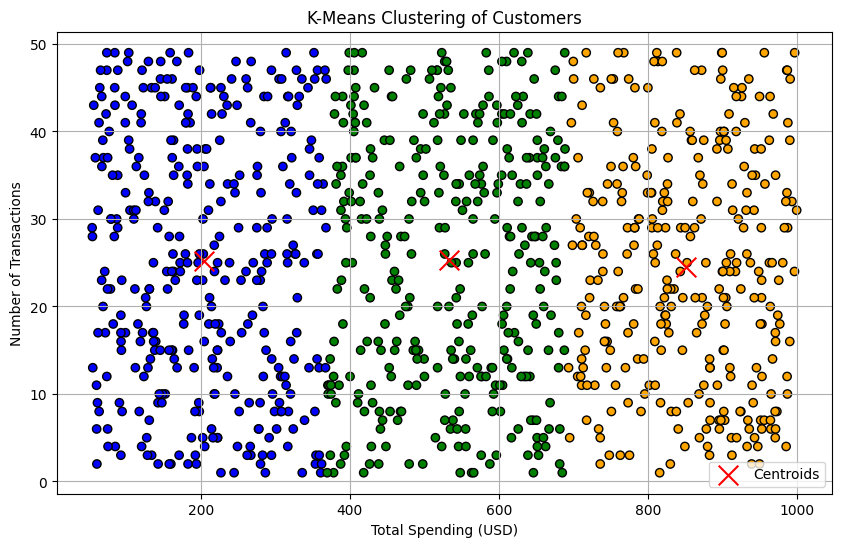

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

predictions_pd = predictions.toPandas()

centers = model.clusterCenters()

centers_df = pd.DataFrame(centers, columns=["Total_Spending", "Num_Transactions"])

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['Total_Spending'], predictions_pd['Num_Transactions'], c=predictions_pd['prediction'], cmap=ListedColormap(['orange', 'blue', 'green']), marker='o', edgecolor='k')
plt.scatter(centers_df['Total_Spending'], centers_df['Num_Transactions'], c='red', marker='x', s=200, label='Centroids')
plt.title('K-Means Clustering of Customers')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.show()
